In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, get_window, chirp
from numpy.fft import fft
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [ ]:
fs = 1000        # Частота дискретизации
T = 2            # Длительность сигнала
t = np.linspace(0, T, int(fs*T), endpoint=False)

f1, f2, f3 = 100, 200, 300
A1, A2, A3 = 1.0, 0.5, 0.2

signal_clean = A1*np.sin(2*np.pi*f1*t) + A2*np.sin(2*np.pi*f2*t) + A3*np.sin(2*np.pi*f3*t)

In [ ]:
def add_noise(signal, snr_db):
    signal_power = np.mean(signal**2)
    snr_linear = 10**(snr_db / 10)
    noise_power = signal_power / snr_linear
    noise = np.random.normal(0, np.sqrt(noise_power), size=signal.shape)
    return signal + noise

In [ ]:
def bartlett_psd(x, fs, n_segments):
    N = len(x)
    segment_length = N // n_segments
    psd_sum = np.zeros(segment_length)

    for i in range(n_segments):
        start = i * segment_length
        segment = x[start:start + segment_length]
        windowed = segment * np.ones_like(segment)
        spectrum = np.abs(fft(windowed))**2
        psd_sum += spectrum[:segment_length]

    psd_avg = psd_sum / n_segments
    freqs = np.fft.fftfreq(segment_length, 1/fs)[:segment_length]
    return freqs, psd_avg

In [ ]:
def welch_psd_custom(x, fs, segment_length, window_type='hann'):
    window = get_window(window_type, segment_length)
    noverlap = segment_length // 2
    freqs, psd = welch(x, fs=fs, window=window, nperseg=segment_length, noverlap=noverlap)
    return freqs, psd

In [ ]:
def plot_psds(snr_list, method='both', N_fft=256):
    n_segments = len(signal_clean) // N_fft
    plt.figure(figsize=(16, 10))
    for i, snr in enumerate(snr_list, 1):
        noisy = add_noise(signal_clean, snr)

        if method in ['both', 'bartlett']:
            f_b, psd_b = bartlett_psd(noisy, fs, n_segments)
            plt.subplot(len(snr_list), 2, 2*i - 1)
            plt.semilogy(f_b, psd_b)
            plt.title(f'Бартлетт, SNR={snr} дБ')
            plt.xlabel('Частота (Гц)')
            plt.ylabel('СПМ')

        if method in ['both', 'welch']:
            f_w, psd_w = welch_psd_custom(noisy, fs, N_fft)
            plt.subplot(len(snr_list), 2, 2*i)
            plt.semilogy(f_w, psd_w)
            plt.title(f'Уэлч, SNR={snr} дБ')
            plt.xlabel('Частота (Гц)')
            plt.ylabel('СПМ')

    plt.tight_layout()
    plt.show()

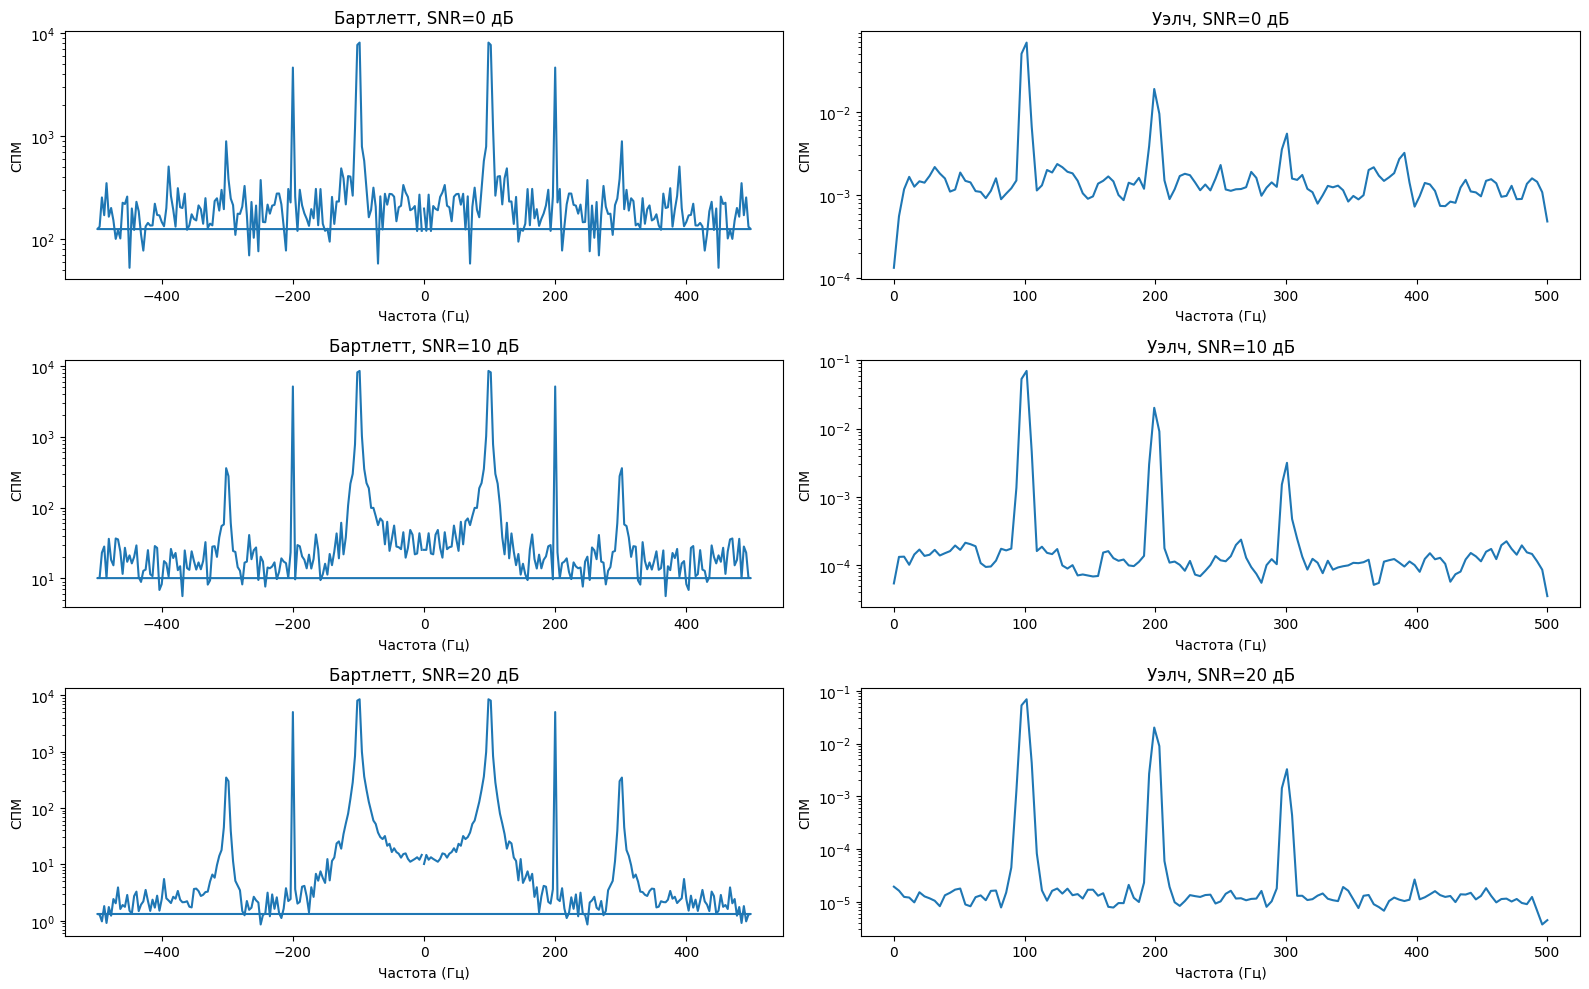

In [ ]:
plot_psds([0, 10, 20], method='both', N_fft=256)

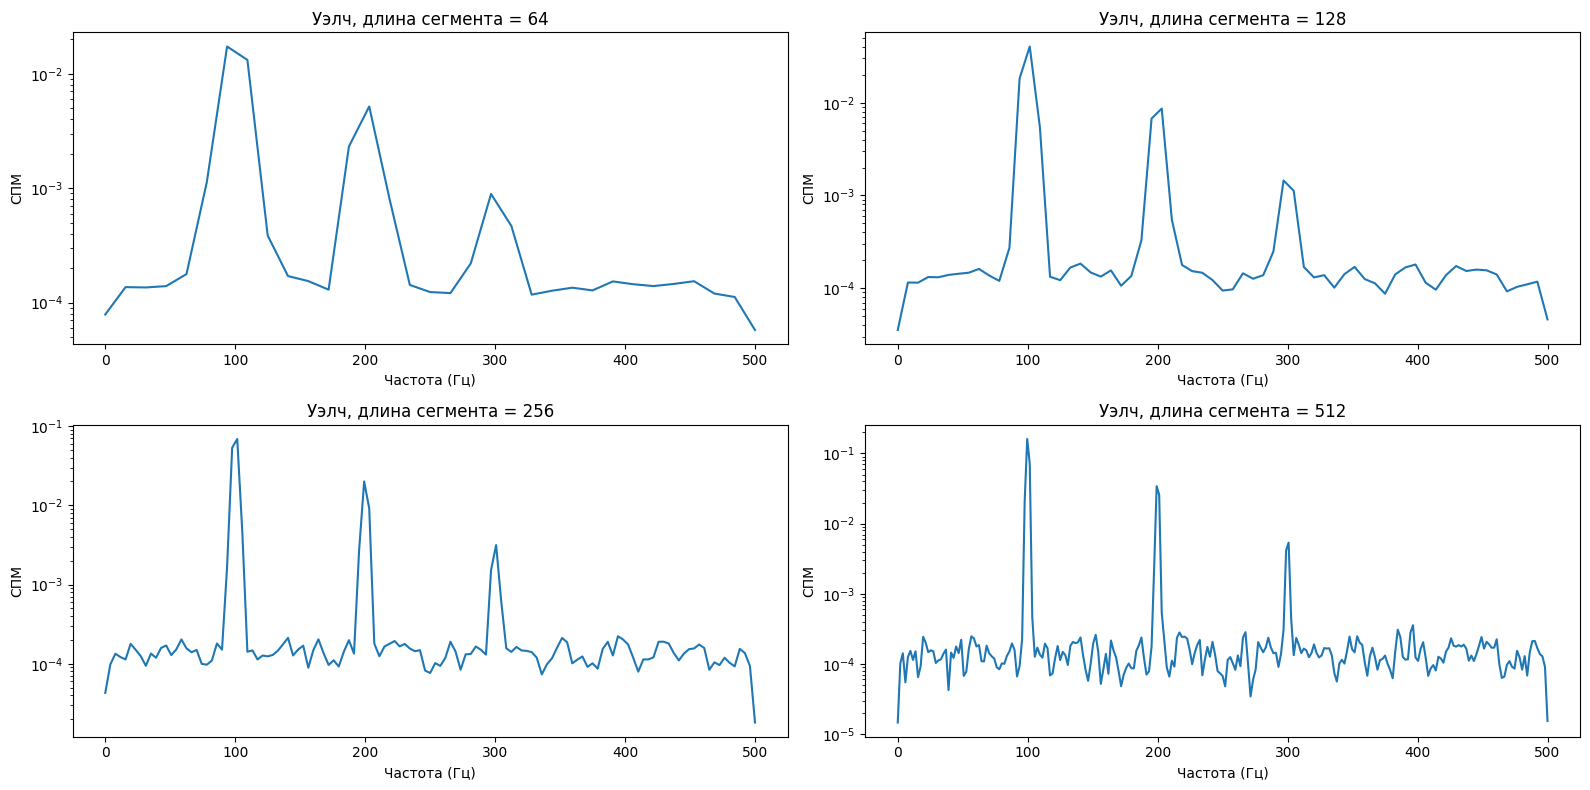

In [ ]:
segment_lengths = [64, 128, 256, 512]

plt.figure(figsize=(16, 8))
noisy = add_noise(signal_clean, 10)

for i, N_fft in enumerate(segment_lengths, 1):
    f, psd = welch_psd_custom(noisy, fs, N_fft)
    plt.subplot(2, 2, i)
    plt.semilogy(f, psd)
    plt.title(f'Уэлч, длина сегмента = {N_fft}')
    plt.xlabel('Частота (Гц)')
    plt.ylabel('СПМ')

plt.tight_layout()
plt.show()

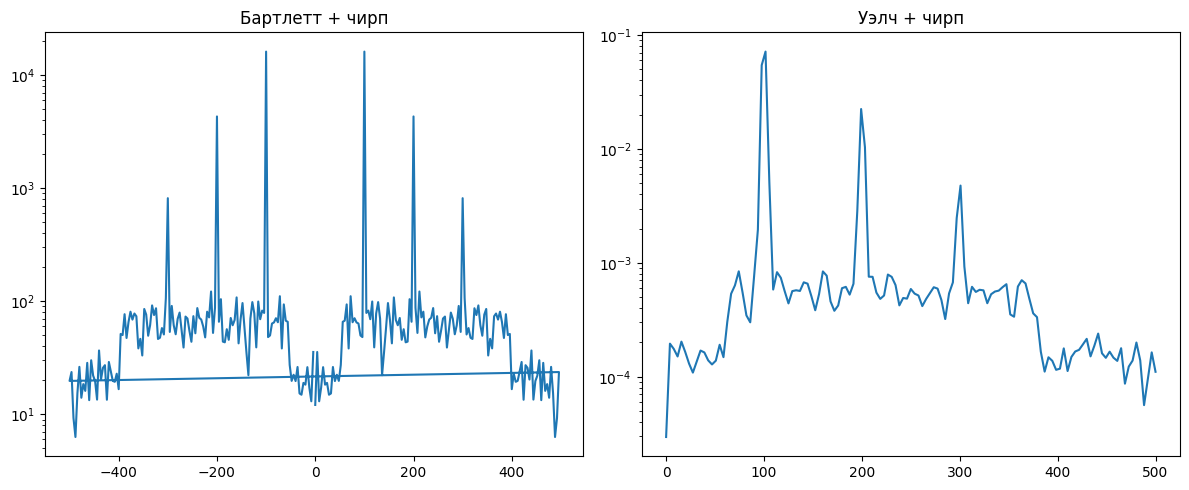

In [ ]:
chirp_signal = chirp(t, f0=50, f1=400, t1=T, method='linear')
signal_with_chirp = signal_clean + 0.5 * chirp_signal
noisy_chirp = add_noise(signal_with_chirp, 10)

f_b, psd_b = bartlett_psd(noisy_chirp, fs, 8)
f_w, psd_w = welch_psd_custom(noisy_chirp, fs, 256)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.semilogy(f_b, psd_b)
plt.title('Бартлетт + чирп')

plt.subplot(1, 2, 2)
plt.semilogy(f_w, psd_w)
plt.title('Уэлч + чирп')

plt.tight_layout()
plt.show()